In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(1234)
pd.set_option("display.max_columns", None)
sns.set_style("darkgrid")


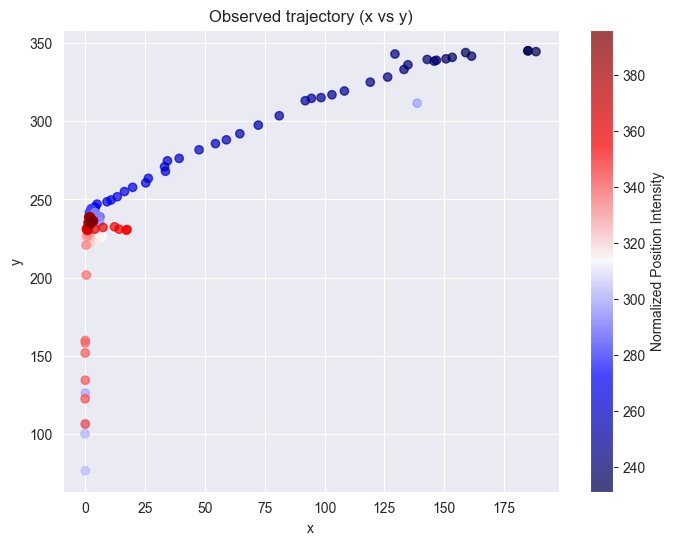

In [2]:
import matplotlib.cm as cm

# Read tracked positions (expects columns 'x' and 'y')
df = pd.read_csv("../results/track_position.csv")
df.head()
df = df.where(df["time"] > 200)
df = df.dropna()

observations = df[["x1", "y1"]].to_numpy()


T = len(observations)
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    observations[:, 0], observations[:, 1], alpha=0.7, c=df["time"], cmap=cm.seismic
)
plt.title("Observed trajectory (x vs y)")
plt.xlabel("x")
plt.ylabel("y")
# plt.axis("equal")
plt.colorbar(sc, label="Normalized Position Intensity")
plt.show()

In [3]:
observations

array([[1.88272232e+02, 3.44450043e+02],
       [1.84852158e+02, 3.44937958e+02],
       [1.85014709e+02, 3.45041412e+02],
       [1.58890610e+02, 3.43855408e+02],
       [1.61377411e+02, 3.41566772e+02],
       [1.53303131e+02, 3.40797485e+02],
       [1.50702759e+02, 3.39858765e+02],
       [1.46688416e+02, 3.38965729e+02],
       [1.45810516e+02, 3.38380829e+02],
       [1.42852890e+02, 3.39443024e+02],
       [1.34808731e+02, 3.36055450e+02],
       [1.33169159e+02, 3.33066589e+02],
       [1.29386948e+02, 3.42946960e+02],
       [1.26342201e+02, 3.28215820e+02],
       [1.19074844e+02, 3.24951965e+02],
       [1.08281921e+02, 3.19295746e+02],
       [1.03081345e+02, 3.16896912e+02],
       [9.85447769e+01, 3.15073517e+02],
       [9.45246048e+01, 3.14615265e+02],
       [9.19363403e+01, 3.13098785e+02],
       [8.10828781e+01, 3.03487152e+02],
       [7.23301315e+01, 2.97495819e+02],
       [6.46151962e+01, 2.91990814e+02],
       [5.90017738e+01, 2.88086792e+02],
       [5.443841

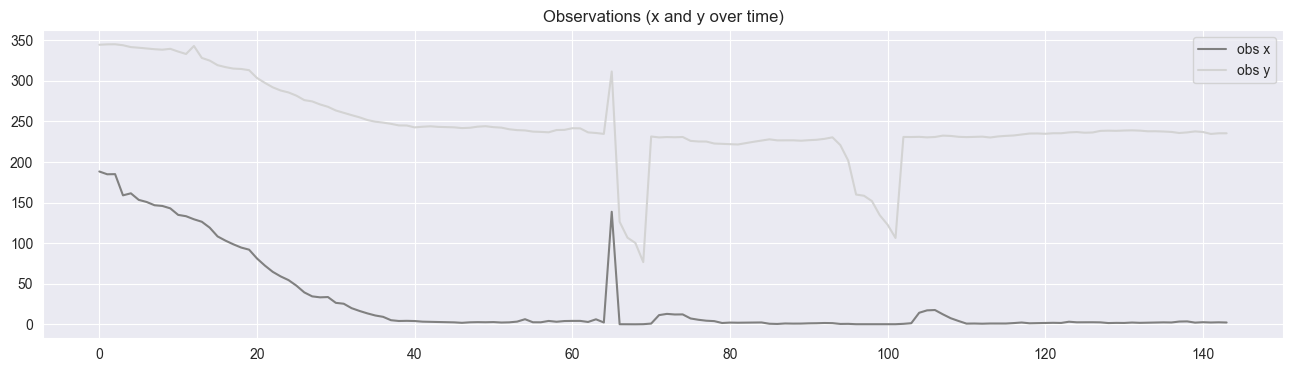

In [4]:
# Model matrices for 2D position-only state (position x,y as state)
# If you want to include velocity, expand state and adjust G/F accordingly
n = 2  # state dimension (x, y)
G = np.eye(n, dtype=np.float64)
F = np.eye(n, dtype=np.float64)
# process noise covariance (tune as needed)
W = np.eye(n, dtype=np.float64) * 0.1
# observation noise covariance (tune based on sensor noise)
V = np.eye(n, dtype=np.float64) * 1.0

K = 5  # prediction horizon

fig, ax = plt.subplots(figsize=(16, 4))
# Plot x and y over time separately for a quick look
ax.plot(np.arange(T), observations[:, 0], color="gray", label="obs x")
ax.plot(np.arange(T), observations[:, 1], color="lightgray", label="obs y")
ax.set_title("Observations (x and y over time)")
ax.legend()
plt.show()


In [5]:
# Params
# 初期状態のフィルタリング分布のパラメータ
m0 = np.zeros((n, 1), dtype=np.float64)
C0 = np.eye(n, dtype=np.float64) * 1e7

# 結果を格納するarray: m has shape (T, n, 1), C has shape (T, n, n)
m = np.zeros((T, n, 1), dtype=np.float64)
C = np.zeros((T, n, n), dtype=np.float64)
a_pred = np.zeros((K, n, 1), dtype=np.float64)
R_pred = np.zeros((K, n, n), dtype=np.float64)


In [6]:
# Functions for Kalman Filter and Smoothing (vectorized for general n)
def kalman_filter(m, C, y, G, F, W, V):
    """
    Kalman Filter (one step)
    m: (n,1) previous filtered mean
    C: (n,n) previous filtered covariance
    y: (n,1) observation at current time
    Returns: updated (m, C)
    """
    a = G @ m
    R = G @ C @ G.T + W
    f = F @ a
    Q = F @ R @ F.T + V
    # Kalman gain: K = R F^T Q^{-1}
    K = R @ F.T @ np.linalg.inv(Q)
    m_upd = a + K @ (y - f)
    C_upd = R - K @ F @ R
    return m_upd, C_upd

def kalman_prediction(a, R, G, W):
    """
    One-step prediction for mean and covariance
    """
    a_pred = G @ a
    R_pred = G @ R @ G.T + W
    return a_pred, R_pred


In [7]:
# Kalman filtering over the sequence
for t in range(T):
    y_t = observations[t].reshape(n, 1)
    if t == 0:
        m[t], C[t] = kalman_filter(m0, C0, y_t, G, F, W, V)
    else:
        m[t], C[t] = kalman_filter(m[t - 1], C[t - 1], y_t, G, F, W, V)

# Kalman predictions for K steps ahead from last filtered state
for k in range(K):
    if k == 0:
        a = G @ m[T - 1]
        R = G @ C[T - 1] @ G.T + W
        a_pred[k] = a
        R_pred[k] = R
    else:
        a_pred[k], R_pred[k] = kalman_prediction(a_pred[k - 1], R_pred[k - 1], G, W)


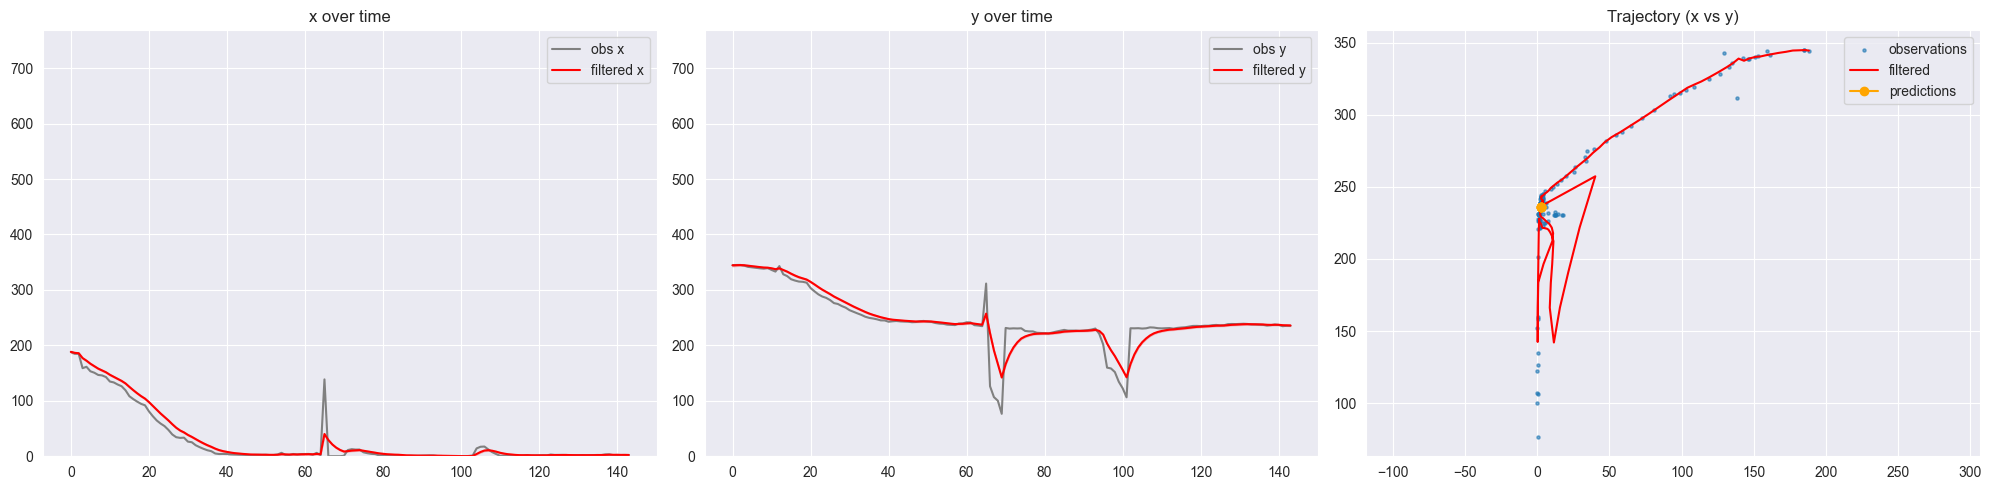

In [8]:
# Plot results: x and y over time and 2D trajectory with predictions
time = np.arange(T)
m_flat = m.reshape(T, n)
a_pred_flat = a_pred.reshape(K, n)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
# x over time
axes[0].plot(time, observations[:, 0], color="gray", label="obs x")
axes[0].plot(time, m_flat[:, 0], color="red", label="filtered x")
# 95% intervals using marginal variance
axes[0].fill_between(
    time,
    m_flat[:, 0] - 1.96 * np.sqrt(C[:, 0, 0]),
    m_flat[:, 0] + 1.96 * np.sqrt(C[:, 0, 0]),
    color="red",
    alpha=0.2,
)
axes[0].set_title("x over time")
axes[0].set_ylim([0, 432])
axes[0].set_ylim([0, 768])
axes[0].legend()

# y over time
axes[1].plot(time, observations[:, 1], color="gray", label="obs y")
axes[1].plot(time, m_flat[:, 1], color="red", label="filtered y")
axes[1].fill_between(
    time,
    m_flat[:, 1] - 1.96 * np.sqrt(C[:, 1, 1]),
    m_flat[:, 1] + 1.96 * np.sqrt(C[:, 1, 1]),
    color="red",
    alpha=0.2,
)
axes[1].set_title("y over time")
axes[1].set_ylim([0, 432])
axes[1].set_ylim([0, 768])
axes[1].legend()

# 2D trajectory
axes[2].scatter(
    observations[:, 0], observations[:, 1], s=5, label="observations", alpha=0.6
)
axes[2].plot(m_flat[:, 0], m_flat[:, 1], color="red", label="filtered")
# plot predictions (from last filtered state)
pred_times = np.arange(T, T + K)
axes[2].plot(
    a_pred_flat[:, 0],
    a_pred_flat[:, 1],
    color="orange",
    marker="o",
    label="predictions",
)
axes[2].set_title("Trajectory (x vs y)")
axes[2].legend()
axes[2].set_ylim([0, 432])
axes[2].set_ylim([0, 768])
axes[2].axis("equal")

plt.tight_layout()
plt.show()


In [9]:
# End of notebook - you can tune W and V or extend the state to include velocity.
